In [ ]:
!pip install anndata scanpy biopython flair python-igraph scipy scikit-learn louvain -q
!pip install tensorflow==2.4.0

In [1]:
!git clone https://github.com/brianhie/viral-mutation.git
%cd viral-mutation
!mkdir data
!mkdir data/aav

Cloning into 'viral-mutation'...
remote: Enumerating objects: 1111, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 1111 (delta 133), reused 117 (delta 66), pack-reused 890
Receiving objects: 100% (1111/1111), 177.41 MiB | 15.13 MiB/s, done.
Resolving deltas: 100% (741/741), done.
/content/viral-mutation


In [2]:
import gc
gc.collect()

228

In [3]:
%cd bin

from mutation import *

np.random.seed(1)
random.seed(1)

/content/viral-mutation/bin


In [4]:
AAs = [ 'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
        'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W',
        'Y', 'V', 'X', 'Z', 'J', 'U', 'B', 'Z']

vocabulary = { aa: idx + 1 for idx, aa in enumerate(sorted(AAs)) }

In [80]:
def load_meta(meta_fnames):
    metas = {}
    for fname in meta_fnames:
        with open(fname) as f:
            for line in f:
                fields = line.rstrip().split('\t')

                accession, host, species, virus_type, protein = (
                    fields[0], fields[20], fields[5], fields[21], fields[15]
                )

                metas[accession] = {
                    'host': host,
                    'virus_type': virus_type,
                    'species': species,
                    'protein': protein,
                }
    return metas


def process(fnames, meta_fnames):
    metas = load_meta(meta_fnames)

    seqs = {}
    for fname in fnames:
        for record in SeqIO.parse(fname, 'fasta'):
            if record.seq not in seqs:
                seqs[record.seq] = []
            accession = record.description.split(' ')[0]

            if '|' in accession:
              accession = accession.split('|')[1]
            seqs[record.seq].append(metas[accession])
    return seqs

def split_seqs(seqs, test_split=0.1):
    train_seqs, test_seqs = {}, {}

    list_seq = [seq for seq in seqs]
    import random

    list_train = random.sample(list_seq, int(len(seqs)*(1-test_split)))
    list_test = [seq for seq in list_seq if seq not in list_train]

    for seq in list_test:
      test_seqs[seq] = seqs[seq]
    
    for seq in list_train:
      train_seqs[seq] = seqs[seq]
    tprint('{} train seqs, {} test seqs.'
           .format(len(train_seqs), len(test_seqs)))

    return train_seqs, test_seqs

def featurize_seqs(seqs, vocabulary):
    start_int = len(vocabulary) + 1
    end_int = len(vocabulary) + 2
    sorted_seqs = sorted(seqs.keys())
    X = np.concatenate([
        np.array([ start_int ] + [
            vocabulary[word] for word in seq
        ] + [ end_int ]) for seq in sorted_seqs
    ]).reshape(-1, 1)
    lens = np.array([ len(seq) + 2 for seq in sorted_seqs ])
    assert(sum(lens) == X.shape[0])
    return X, lens

In [81]:
fnames = [ '/content/drive/MyDrive/aav_immune_escape/Dependoparvovirus.fa' ]
meta_fnames = [ '/content/drive/MyDrive/aav_immune_escape/Dependoparvovirus_metadata.txt' ]

seqs = process(fnames, meta_fnames)
seq_len = max([ len(seq) for seq in seqs ]) + 2
vocab_size = len(AAs) + 2

In [82]:
seqs

{Seq('DDEDLVARQQAAQSGAEGTGSSAPAANPDLGPTTMSGGGGAPMADDQQGADGVG...RTL'): [{'host': 'fox',
   'protein': 'capsid protein',
   'species': 'Fox adeno-associated virus',
   'virus_type': 'Adeno-associated virus'}],
 Seq('DSSSGTGKSGQQPARKRLNFGQTGDADSVPDPQPLGQPPAAPSGLGTNTMATGS...RNL'): [{'host': 'human',
   'protein': 'VP1',
   'species': 'Adeno-associated dependoparvovirus A',
   'virus_type': 'Adeno-associated dependoparvovirus A'}],
 Seq('GGADGVGNASGNWHCDSQWMGNTVITKTTRTWVLPSYNNHIYKAITSGTSQDAN...EDR'): [{'host': 'birds',
   'protein': 'capsid protein',
   'species': 'Anseriform dependoparvovirus 1',
   'virus_type': 'Goose parvovirus'}],
 Seq('GLVEEPINTAPAKKNTGKLTDHYPVVKKPKLTEEVSAGGGSSVVQDGGATAEGT...QNL'): [{'host': 'birds',
   'protein': 'VP2',
   'species': 'Anseriform dependoparvovirus 1',
   'virus_type': 'Duck parvovirus'}],
 Seq('GLVEEPINTAPAKKNTGKLTDHYPVVKKPKLTEEVSAGGGSSVVQDGGATAEGT...QNL'): [{'host': 'birds',
   'protein': 'VP2',
   'species': 'Anseriform dependoparvovirus 1',
   'vir

In [83]:
train_seqs, test_seqs = split_seqs(seqs, test_split=0.0)

2022-04-19 15:08:21.759508 | 680 train seqs, 0 test seqs.


In [84]:
X_train, lengths = featurize_seqs(train_seqs, vocabulary)

# use prebuilt model

In [85]:
from language_model import BiLSTMLanguageModel
import tensorflow as tf
print(tf.__version__)

model = BiLSTMLanguageModel(
    seq_len,
    vocab_size,
    embedding_dim=20,
    hidden_dim=512,
    n_hidden=2,
    n_epochs=3,
    batch_size=200,
    inference_batch_size=200,
    cache_dir='./{}'.format('aav'),
    seed=1,
    verbose=True,
    )

model.model_.load_weights('/content/drive/MyDrive/aav_immune_escape/checkpoints/bilstm_512-04.hdf5')
model.model_.summary()

2.4.0
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 761)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 761)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 761, 20)      580         input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 761, 512)     1091584     embedding_5[0][0]    

# train the model

In [ ]:
model.fit(X_train, lengths)

In [ ]:
report_performance('bilstm', model, vocabulary, train_seqs, test_seqs)

# built from scratch

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


if X_cat.shape[0] != sum(lengths):
  raise ValueError('Length dimension mismatch: {} and {}'.format(X_cat.shape[0], sum(lengths)))

tprint('Splitting {} seqs...'.format(len(lengths)))
X_seqs = [X_cat[start:end].flatten() for start, end in iterate_lengths(lengths, seq_len)]

X_pre = [X_seq[:i] for X_seq in X_seqs for i in range(len(X_seq))]
X_post = [X_seq[i + 1:] for X_seq in X_seqs for i in range(len(X_seq))]
        
y = np.array([X_seq[i] for X_seq in X_seqs for i in range(len(X_seq))])


tprint('Padding {} splitted...'.format(len(X_pre)))
X_pre = pad_sequences(X_pre, maxlen=seq_len - 1,
                      dtype='int32', padding='pre', truncating='pre', value=0)


tprint('Padding {} splitted again...'.format(len(X_pre)))
X_post = pad_sequences(X_post, maxlen=seq_len - 1,
                       dtype='int32', padding='post', truncating='post', value=0)

tprint('Flipping...')
X_post = np.flip(X_post, 1)
X = [ X_pre, X_post ]

tprint('Done splitting and padding.')



In [ ]:
del X_cat
del train_seqs
del X_pre
del X_post
gc.collect()

In [ ]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (
    concatenate, Activation, Dense, Embedding, LSTM, Reshape)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
embedding_dim=20
hidden_dim=512
n_hidden=2

input_pre = Input(shape=(seq_len - 1,))
input_post = Input(shape=(seq_len - 1,))

embed = Embedding(vocab_size + 1, embedding_dim,
                  input_length=seq_len - 1)

x_pre = embed(input_pre)
x_post = embed(input_post)

for _ in range(n_hidden - 1):
  lstm = LSTM(hidden_dim, return_sequences=True)
  x_pre = lstm(x_pre)
  x_post = lstm(x_post)

lstm = LSTM(hidden_dim)
x_pre = lstm(x_pre)
x_post = lstm(x_post)

x = concatenate([ x_pre, x_post ], name='embed_layer')

#x = Dense(dff, activation='relu')(x)
x = Dense(vocab_size + 1)(x)
output = Activation('softmax', dtype='float32')(x)

model = Model(inputs=[ input_pre, input_post ],
               outputs=output)


model.load_weights('/content/viral-mutation/models/flu.hdf5')
model.summary()


In [ ]:
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=opt,
              metrics=[ 'accuracy' ]
              )

model.fit(X, y, 
          epochs=4, 
          batch_size=100,
          shuffle=True, verbose=1)

In [ ]:
report_performance('bilstm', model, vocabulary, train_seqs, val_seqs)

# embedding

In [86]:
def embed_seqs(model, seqs, vocabulary):
  X_cat, lengths = featurize_seqs(seqs, vocabulary)
  embed_fname = ('aav/embedding/{}_{}.npy'
                       .format('bilstm', 512))
  X_embed = model.transform(X_cat, lengths, embed_fname)
  
  sorted_seqs = sorted(seqs)
  for seq_idx, seq in enumerate(sorted_seqs):
    for meta in seqs[seq]:
      meta['embedding'] = X_embed[seq_idx]
  
  return seqs

embed_seqs = embed_seqs(model, seqs, vocabulary)



import pickle 
pickle.dump(embed_seqs, open('/content/drive/MyDrive/aav_immune_escape/embed_seqs', 'wb'))

2022-04-19 15:08:31.961309 | Embedding...
2306/2306 [==============================] - 1737s 753ms/step
2022-04-19 15:37:30.091147 | Done embedding.


/content/viral-mutation/bin/language_model.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  iterate_lengths(lengths, self.seq_len_)


In [10]:
import pickle

embed_seqs = pickle.load(open('/content/drive/MyDrive/aav_immune_escape/embed_seqs', 'rb'))

In [87]:
if 1:
    X, obs = [], {}
    obs['n_seq'] = []
    obs['seq'] = []

    for seq in embed_seqs:
        meta = embed_seqs[seq][0]
        X.append(meta['embedding'].mean(0))
        for key in meta:
            if key == 'embedding':
                continue
            if key not in obs:
                obs[key] = []
            obs[key].append(Counter([
                meta[key] for meta in embed_seqs[seq]
            ]).most_common(1)[0][0])
        obs['n_seq'].append(len(embed_seqs[seq]))
        obs['seq'].append(str(seq))
    X = np.array(X)

    adata = AnnData(X)
    for key in obs:
        adata.obs[key] = obs[key]

adata

AnnData object with n_obs × n_vars = 680 × 1024
    obs: 'n_seq', 'seq', 'host', 'virus_type', 'species', 'protein'

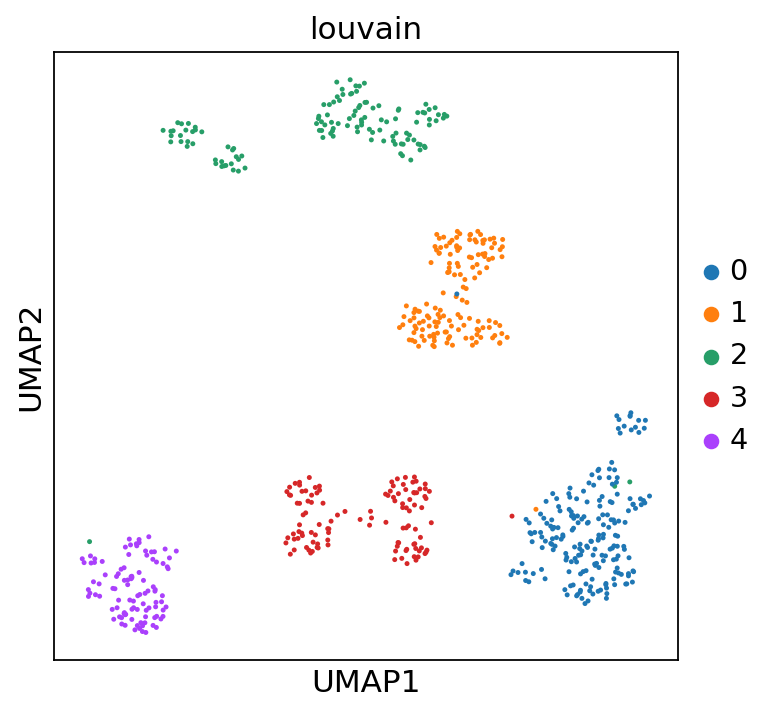

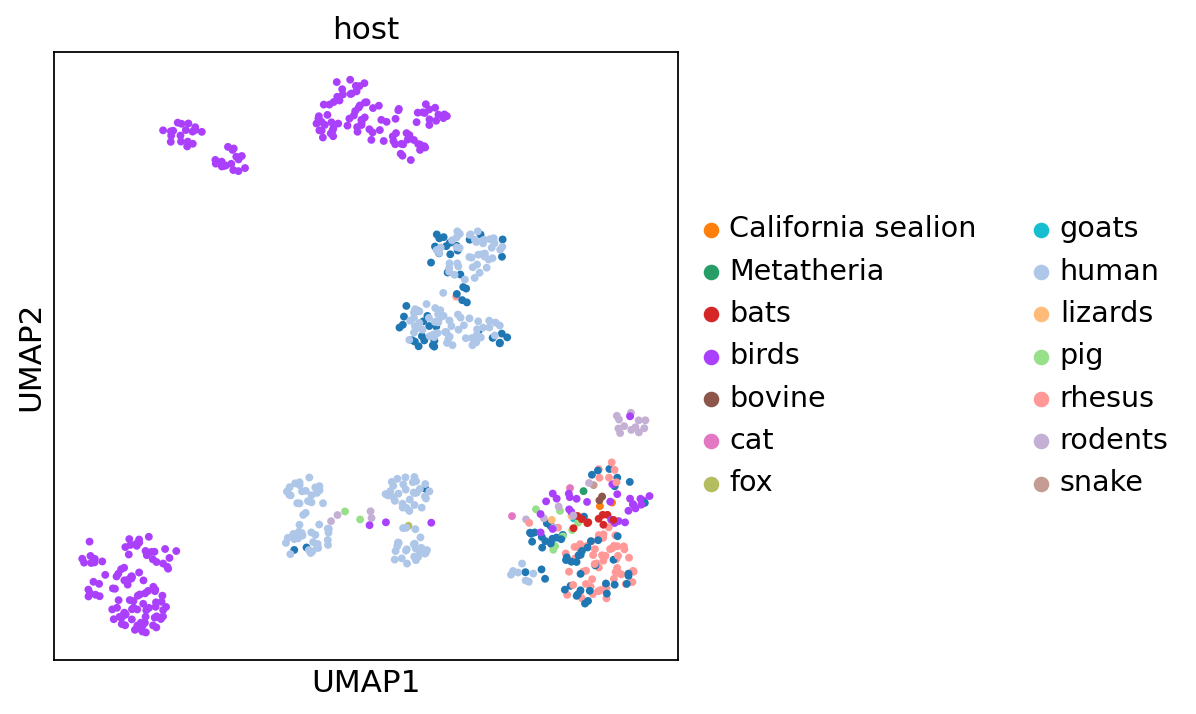

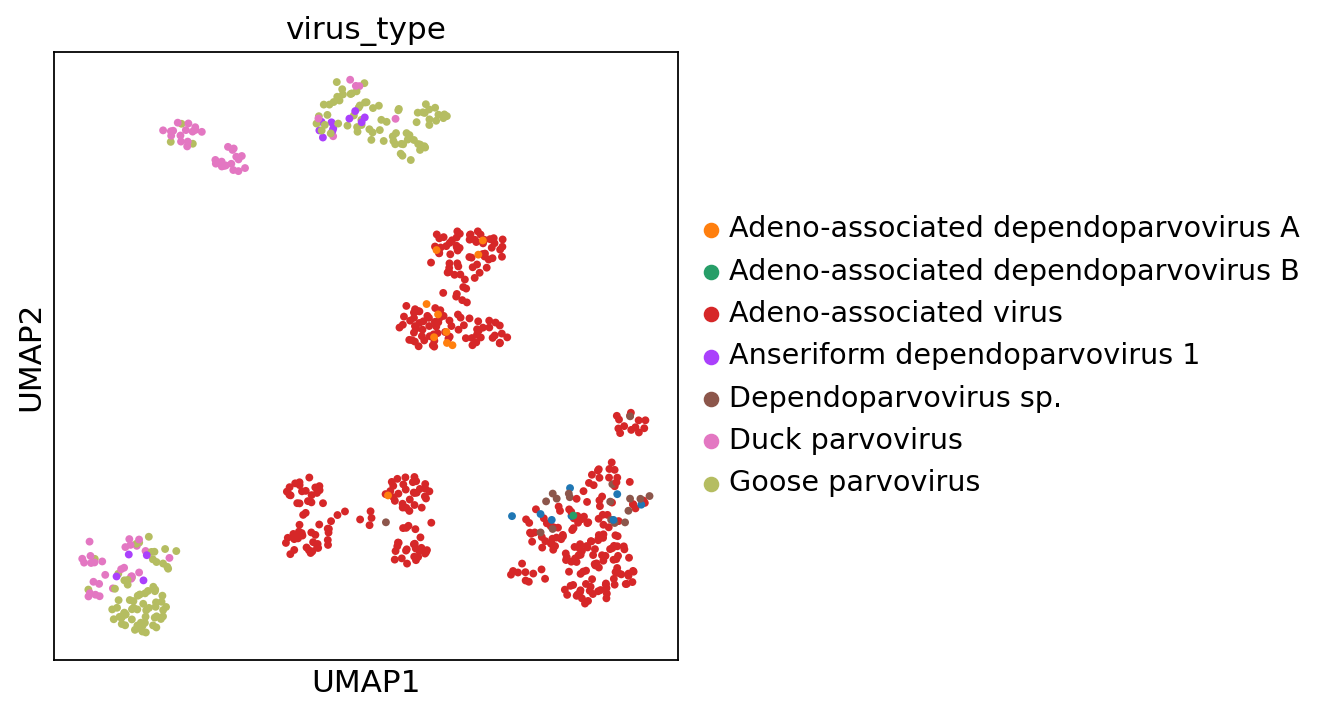

In [88]:
sc.pp.neighbors(adata, n_neighbors=100, use_rep='X')
sc.tl.louvain(adata, resolution=1.)
sc.set_figure_params(dpi_save=500, figsize=(5,5))
sc.tl.umap(adata, min_dist=1.)

sc.pl.umap(adata, color='louvain', size=20)
sc.pl.umap(adata, color='host', size=50)
sc.pl.umap(adata, color='virus_type', size=50)

In [89]:
#####not yet done

def interpret_clusters(adata):
    clusters = sorted(set(adata.obs['louvain']))
    for cluster in clusters:
        tprint('Cluster {}'.format(cluster))
        adata_cluster = adata[adata.obs['louvain'] == cluster]
        for var in [ 'host', 'virus_type', 'species']:
            tprint('\t{}:'.format(var))
            counts = Counter(adata_cluster.obs[var])
            for val, count in counts.most_common():
                tprint('\t\t{}: {}'.format(val, count))
        tprint('')

    cluster2subtype = {}
    cluster2species = {}
    for i in range(len(adata)):
        cluster = adata.obs['louvain'][i]
        if cluster not in cluster2subtype:
            cluster2subtype[cluster] = []
            cluster2species[cluster] = []
        cluster2subtype[cluster].append(adata.obs['virus_type'][i])
        cluster2species[cluster].append(adata.obs['host'][i])
    largest_pct_subtype = []
    largest_pct_species = []
    for cluster in cluster2subtype:
        count = Counter(cluster2subtype[cluster]).most_common(1)[0][1]
        largest_pct_subtype.append(float(count) /
                                   len(cluster2subtype[cluster]))
        count = Counter(cluster2species[cluster]).most_common(1)[0][1]
        largest_pct_species.append(float(count) /
                                   len(cluster2species[cluster]))


    for idx, pct in enumerate(largest_pct_subtype):
        tprint('\tCluster {}, largest subtype % = {}'.format(idx, pct))
    for idx, pct in enumerate(largest_pct_species):
        tprint('\tCluster {}, largest species % = {}'.format(idx, pct))

    tprint('Purity, Louvain and subtype: {}'
           .format(np.mean(largest_pct_subtype)))
    tprint('Purity, Louvain and host species: {}'
           .format(np.mean(largest_pct_species)))
    
    
interpret_clusters(adata)

2022-04-19 15:47:20.389440 | Cluster 0
2022-04-19 15:47:20.396051 | 	host:
2022-04-19 15:47:20.397025 | 		rhesus: 63
2022-04-19 15:47:20.397806 | 		: 54
2022-04-19 15:47:20.400614 | 		birds: 29
2022-04-19 15:47:20.401490 | 		rodents: 19
2022-04-19 15:47:20.402563 | 		bats: 10
2022-04-19 15:47:20.403486 | 		human: 7
2022-04-19 15:47:20.404320 | 		pig: 6
2022-04-19 15:47:20.405151 | 		bovine: 2
2022-04-19 15:47:20.406131 | 		California sealion: 2
2022-04-19 15:47:20.406939 | 		lizards: 2
2022-04-19 15:47:20.407824 | 		snake: 1
2022-04-19 15:47:20.408762 | 		goats: 1
2022-04-19 15:47:20.409686 | 		Metatheria: 1
2022-04-19 15:47:20.410775 | 		cat: 1
2022-04-19 15:47:20.411864 | 	virus_type:
2022-04-19 15:47:20.413176 | 		Adeno-associated virus: 173
2022-04-19 15:47:20.414212 | 		Dependoparvovirus sp.: 17
2022-04-19 15:47:20.414934 | 		: 7
2022-04-19 15:47:20.415955 | 		Adeno-associated dependoparvovirus B: 1
2022-04-19 15:47:20.417228 | 	species:
2022-04-19 15:47:20.418326 | 		Adeno-associ

In [ ]:
def seq_clusters(adata):
    clusters = sorted(set(adata.obs['louvain']))
    for cluster in clusters:
        adata_cluster = adata[adata.obs['louvain'] == cluster]
        counts = Counter(adata_cluster.obs['seq'])
        with open('target/flu/clusters/cluster{}.fa'.format(cluster), 'w') as of:
            for i, (seq, count) in enumerate(counts.most_common()):
                of.write('>cluster{}_{}_{}\n'.format(cluster, i, count))
                of.write(seq + '\n\n')

seq_clusters(adata)

#sematic changes

In [ ]:
%cd /content/viral-mutation
!wget http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz
!tar xvf data.tar.gz

In [19]:
%cd /content/viral-mutation/bin

/content/viral-mutation/bin


In [93]:
def load_aav2_A20(antibody_cutoff=1.5, exp_cutoff=0.5):
    seq = SeqIO.read('/content/viral-mutation/data/aav/aav2_VP1_wt.fasta', 'fasta').seq

    exps = {}
    with open('/content/drive/MyDrive/aav_immune_escape/REP2_aa_freq.txt', 'r') as f:
      for line in f:
        fields = line.rstrip().split('\t')
        
        if fields[3] == 'sub' and fields[1] != '*':
                pos = int(float(fields[0]) - 1)
                aa_orig = seq[pos]
                aa_mut = fields[1]

                escaped = seq[:pos] + aa_mut + seq[pos + 1:]
                assert(len(seq) == len(escaped))

                #log2 expression
                if fields[4] == 'NA':
                  exp = float('-inf')
                else:
                  exp = float(fields[4])

                exps[escaped] = exp

    aa_binding_a20 = np.array([261,262,263,264,384,385,708,717,258,253,254,658,659,660,548,556])
    aa_binding_a20 = aa_binding_a20-1
    aa_binding_a20 = aa_binding_a20.tolist()

    seqs_escape = {}
    with open('/content/drive/MyDrive/aav_immune_escape/ab_selection.txt', 'r') as f:
      for line in f:
        fields = line.rstrip().split('\t')
        
        if fields[3] == 'sub' and fields[1] != '*':
                pos = int(float(fields[0]) - 1)
                aa_orig = seq[pos]
                aa_mut = fields[1]

                escaped = seq[:pos] + aa_mut + seq[pos + 1:]
                assert(len(seq) == len(escaped))

                if escaped not in seqs_escape:
                  seqs_escape[escaped] = []

                #log2 antibody selection
                if fields[4] == 'NA':
                  score = float('-inf')
                else:
                  score = float(fields[4])

                #significant change or not? (based on the A20 binding distribution)
                #https://github.com/churchlab/AAV_fitness_landscape/blob/master/x02_analysis/a03_analyze_thermostability_and_antibody_data.ipynb
                significant = (score >= antibody_cutoff and 
                               exps[escaped] >= exp_cutoff
                               #pos in aa_binding_a20
                               )


                seqs_escape[escaped].append({'pos': pos,
                                             'score': score,
                                             'significant': significant,
                                             })
    return seq, seqs_escape

seq_to_mutate, seqs_escape = load_aav2_A20()

In [24]:
def predict_sequence_prob(seq_of_interest, vocabulary, model,
                          verbose=False):
    seqs = { seq_of_interest: [ {} ] }
    X_cat, lengths = featurize_seqs(seqs, vocabulary)

    y_pred = model.predict(X_cat, lengths)
    assert(y_pred.shape[0] == len(seq_of_interest) + 2)

    return y_pred

y_pred = predict_sequence_prob(seq_to_mutate, vocabulary, model, verbose=True)

In [25]:
min_pos = 0
#max_pos = 600
max_pos = len(seq_to_mutate) - 1
prob_cutoff=0.


word_pos_prob = {}
for i in range(min_pos, max_pos + 1):
  for word in vocabulary:
    if seq_to_mutate[i] == word: continue
    
    word_idx = vocabulary[word]
    prob = y_pred[i + 1, word_idx]
    word_pos_prob[(word, i)] = prob

prob_seqs = { seq_to_mutate: [ { 'word': None, 'pos': None } ] }

seq_prob = {}
for (word, pos), prob in word_pos_prob.items():
  mutable = seq_to_mutate[:pos] + word + seq_to_mutate[pos + 1:]
  seq_prob[mutable] = prob
  if prob >= prob_cutoff:
    prob_seqs[mutable] = [ { 'word': word, 'pos': pos } ]

seqs = np.array([ str(seq) for seq in sorted(seq_prob.keys()) ])

In [26]:
def embed_seqs(model, seqs, vocabulary):
  X_cat, lengths = featurize_seqs(seqs, vocabulary)
  embed_fname = ('aav/embedding/{}_{}.npy'
                       .format('bilstm', 512))
  X_embed = model.transform(X_cat, lengths, embed_fname)
  
  sorted_seqs = sorted(seqs)
  for seq_idx, seq in enumerate(sorted_seqs):
    for meta in seqs[seq]:
      meta['embedding'] = X_embed[seq_idx]
  
  return seqs


base_embedding = embed_seqs(model, { seq_to_mutate: [ {} ] }, vocabulary)[seq_to_mutate][0]['embedding']

2022-04-19 10:23:19.637445 | Embedding...
4/4 [==============================] - 3s 648ms/step
2022-04-19 10:23:22.294277 | Done embedding.


In [ ]:
comb_batch = 200 #bigger will not fit GPU 16G
n_batches = math.ceil(float(len(seqs)) / comb_batch)
print('len(seqs) = ', len(seqs))
print('n_batches = ', n_batches)

len(seqs) =  4824
n_batches =  25


In [ ]:
if 1:
    seq_change = {}
    for batchi in range(n_batches):
        start = batchi * comb_batch
        end = (batchi + 1) * comb_batch
        prob_seqs_batch = {
            seq: deepcopy(prob_seqs[seq]) for seq in seqs[start:end]
            if seq != seq_to_mutate
        }
        prob_seqs_batch = embed_seqs(model, prob_seqs_batch, vocabulary)
        for mut_seq in prob_seqs_batch:
            meta = prob_seqs_batch[mut_seq][0]
            sem_change = abs(base_embedding - meta['embedding']).sum()
            seq_change[mut_seq] = sem_change
        del prob_seqs_batch
        

In [ ]:
np.save('/content/drive/MyDrive/aav_immune_escape/seq_change', seq_change)

In [35]:
seq_change = np.load('/content/drive/MyDrive/aav_immune_escape/seq_change.npy', allow_pickle=True)
seq_change = seq_change.tolist()

In [17]:
cache_fname = '/analyze_semantics_{}_{}_{}.txt'.format('aav', 'bilstm', '512')

In [36]:
if 1:
    probs, changes = [], []
    with open(cache_fname, 'w') as of:
        fields = [ 'pos', 'wt', 'mut', 'prob', 'change',
                   'is_viable', 'is_escape' ]
        of.write('\t'.join(fields) + '\n')
        for seq in seqs:
            prob = seq_prob[seq]
            change = seq_change[seq]
            mut = prob_seqs[seq][0]['word']
            pos = prob_seqs[seq][0]['pos']
            orig = seq_to_mutate[pos]
            is_viable = seq in seqs_escape
            is_escape = ((seq in seqs_escape) and
                         (sum([ m['significant']
                                for m in seqs_escape[seq] ]) > 0))
            fields = [ pos, orig, mut, prob, change, is_viable, is_escape ]
            of.write('\t'.join([ str(field) for field in fields ]) + '\n')
            probs.append(prob)
            changes.append(change)


In [ ]:
np.save('/content/drive/MyDrive/aav_immune_escape/seqs', seqs) 
np.save('/content/drive/MyDrive/aav_immune_escape/probs', np.array(probs)) 
np.save('/content/drive/MyDrive/aav_immune_escape/changes', np.array(changes))

Number of escape seqs: 34 / 34
Mean rank: 5709.720588235294 / 13581
Median rank: 5593.75 / 13581
Min rank: 232.0 / 13581
Max rank: 13508.0 / 13581
Rank stdev: 3726.1765240129907 / 13581
Escape semantics, beta = 1.0 [semantics]
AUC (CSCS): 0.5796029920693703, P = 0.0488
AUC (semantic change only): 0.3937269628416863
AUC (grammaticality only): 0.7098671587035521
-5.75 (mean log prob), -4.564 (mean log prob escape), 2.299e-05 (p-value)
1720 (mean log change), 1506 (mean log change escape), 0.03205 (p-value)


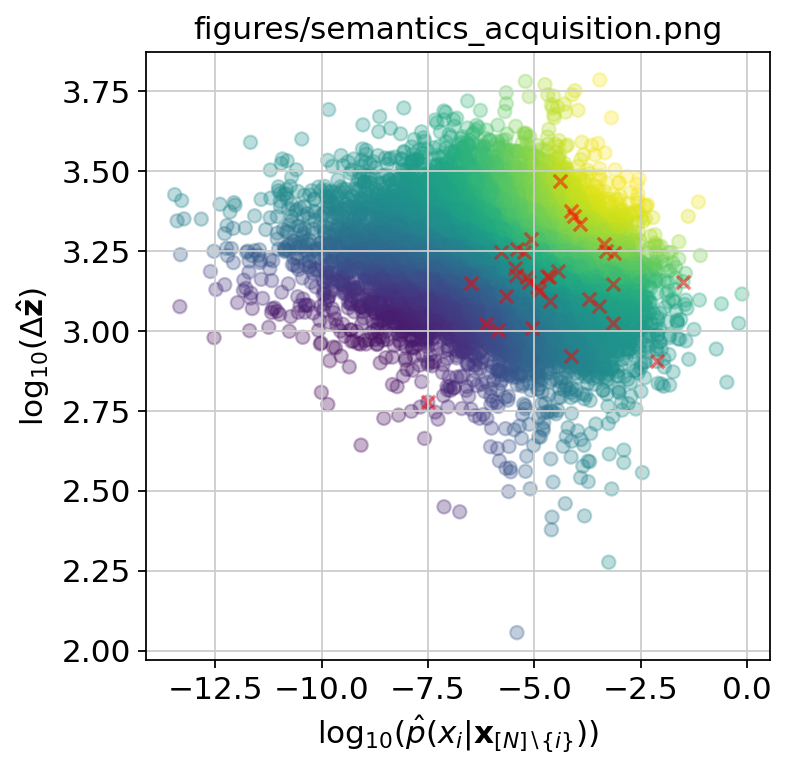

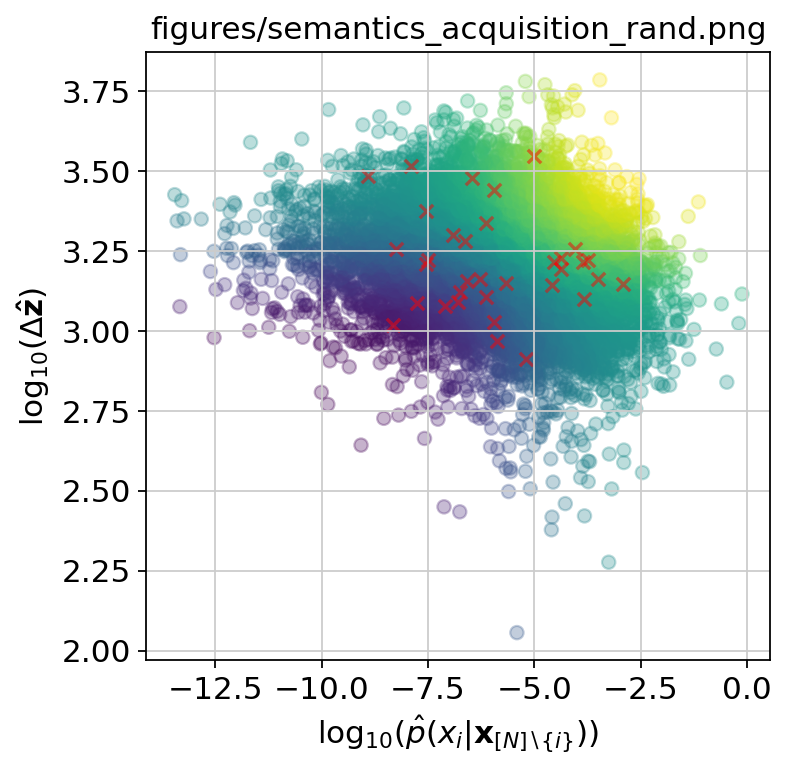

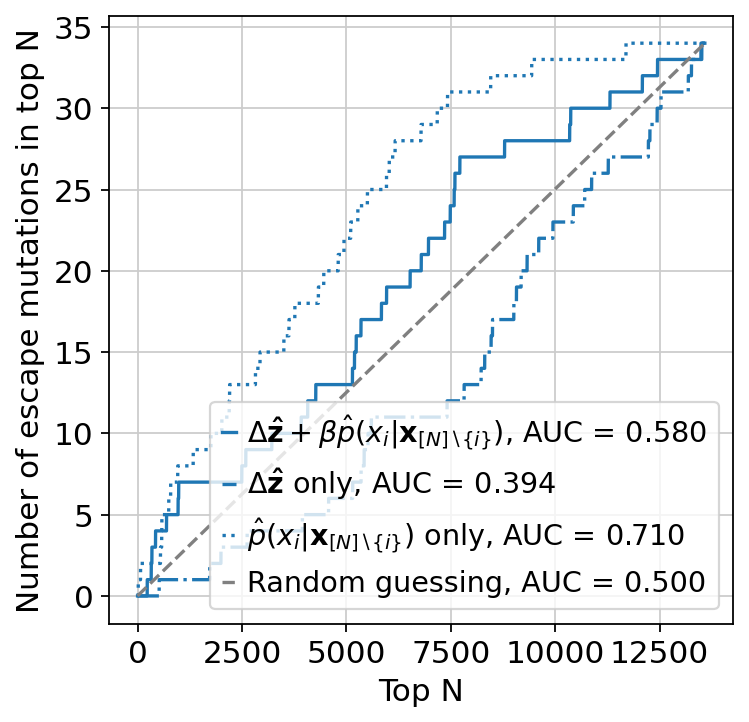

In [94]:
from utils import *
from sklearn.metrics import auc
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt

def cached_escape(cache_fname, beta, plot=True, namespace='semantics'):
    
    wt_seq, seqs_escape = load_aav2_A20(antibody_cutoff=2.5)
    
    prob, change, escape_idx, viable_idx = [], [], [], []
    with open(cache_fname) as f:
        f.readline()
        for line in f:
            fields = line.rstrip().split('\t')
            pos = int(fields[0])
            
            if pos < min_pos or pos > max_pos: continue ### if not run on full protein sequence

            if fields[2] in { 'U', 'B', 'J', 'X', 'Z' }:
                continue
            aa_wt = fields[1]
            aa_mut = fields[2]
            assert(wt_seq[pos] == aa_wt)
            mut_seq = wt_seq[:pos] + aa_mut + wt_seq[pos+1:]
            if mut_seq not in seqs_escape:
                continue
            prob.append(float(fields[3]))
            change.append(float(fields[4]))
            viable_idx.append(fields[5] == 'True')
            escape_idx.append(
                (mut_seq in seqs_escape) and
                (sum([ m['significant']
                       for m in seqs_escape[mut_seq] ]) > 0)
            )

    prob, orig_prob = np.array(prob), np.array(prob)
    change, orig_change  = np.array(change), np.array(change)
    escape_idx = np.array(escape_idx)
    viable_idx = np.array(viable_idx)

    acquisition = ss.rankdata(change) + (beta * ss.rankdata(prob))

    pos_change_idx = change > 0

    pos_change_escape_idx = np.logical_and(pos_change_idx, escape_idx)
    escape_prob = prob[pos_change_escape_idx]
    escape_change = change[pos_change_escape_idx]
    prob = prob[pos_change_idx]
    change = change[pos_change_idx]

    log_prob, log_change = np.log10(prob), np.log10(change)
    log_escape_prob, log_escape_change = (np.log10(escape_prob),
                                          np.log10(escape_change))

    if plot:
        os.makedirs('figures', exist_ok=True)

        plt.figure()
        plt.scatter(log_prob, log_change, c=acquisition[pos_change_idx],
                    cmap='viridis', alpha=0.3)
        plt.scatter(log_escape_prob, log_escape_change, c='red',
                    alpha=0.5, marker='x')
        plt.xlabel(r'$ \log_{10}(\hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} })) $')
        plt.ylabel(r'$ \log_{10}(\Delta \mathbf{\hat{z}}) $')
        plt.title('figures/{}_acquisition.png'
                    .format(namespace))
        plt.savefig('figures/{}_acquisition.png'
                    .format(namespace), dpi=300)
        #plt.close()

        rand_idx = np.random.choice(len(prob), len(escape_prob))
        plt.figure()
        plt.scatter(log_prob, log_change, c=acquisition[pos_change_idx],
                    cmap='viridis', alpha=0.3)
        plt.scatter(log_prob[rand_idx], log_change[rand_idx], c='red',
                    alpha=0.5, marker='x')
        plt.xlabel(r'$ \log_{10}(\hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} })) $')
        plt.ylabel(r'$ \log_{10}(\Delta \mathbf{\hat{z}}) $')
        plt.title('figures/{}_acquisition_rand.png'
                    .format(namespace))
        plt.savefig('figures/{}_acquisition_rand.png'
                    .format(namespace), dpi=300)
        #plt.close()

    if len(escape_prob) == 0:
        print('No escape mutations found.')
        return

    acq_argsort = ss.rankdata(-acquisition)
    escape_rank_dist = acq_argsort[escape_idx]

    size = len(prob)
    print('Number of escape seqs: {} / {}'
          .format(len(escape_rank_dist), sum(escape_idx)))
    print('Mean rank: {} / {}'.format(np.mean(escape_rank_dist), size))
    print('Median rank: {} / {}'.format(np.median(escape_rank_dist), size))
    print('Min rank: {} / {}'.format(np.min(escape_rank_dist), size))
    print('Max rank: {} / {}'.format(np.max(escape_rank_dist), size))
    print('Rank stdev: {} / {}'.format(np.std(escape_rank_dist), size))

    max_consider = len(prob)
    n_consider = np.array([ i + 1 for i in range(max_consider) ])

    n_escape = np.array([ sum(escape_rank_dist <= i + 1)
                          for i in range(max_consider) ])
    norm = max(n_consider) * max(n_escape)
    norm_auc = auc(n_consider, n_escape) / norm

    escape_rank_prob = ss.rankdata(-orig_prob)[escape_idx]
    n_escape_prob = np.array([ sum(escape_rank_prob <= i + 1)
                               for i in range(max_consider) ])
    norm_auc_prob = auc(n_consider, n_escape_prob) / norm

    escape_rank_change = ss.rankdata(-orig_change)[escape_idx]
    n_escape_change = np.array([ sum(escape_rank_change <= i + 1)
                                 for i in range(max_consider) ])
    norm_auc_change = auc(n_consider, n_escape_change) / norm

    if plot:
        plt.figure()
        plt.plot(n_consider, n_escape)
        plt.plot(n_consider, n_escape_change, c='C0', linestyle='-.')
        plt.plot(n_consider, n_escape_prob, c='C0', linestyle=':')
        plt.plot(n_consider, n_consider * (len(escape_prob) / len(prob)),
                 c='gray', linestyle='--')

        plt.xlabel(r'$ \log_{10}() $')
        plt.ylabel(r'$ \log_{10}(\Delta \mathbf{\hat{z}}) $')

        plt.legend([
            r'$ \Delta \mathbf{\hat{z}} + ' +
            r'\beta \hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} }) $,' +
            (' AUC = {:.3f}'.format(norm_auc)),
            r'$  \Delta \mathbf{\hat{z}} $ only,' +
            (' AUC = {:.3f}'.format(norm_auc_change)),
            r'$ \hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} }) $ only,' +
            (' AUC = {:.3f}'.format(norm_auc_prob)),
            'Random guessing, AUC = 0.500'
        ])
        plt.xlabel('Top N')
        plt.ylabel('Number of escape mutations in top N')
        plt.savefig('figures/{}_consider_escape.png'
                    .format(namespace), dpi=300)
        #plt.close()


    print('Escape semantics, beta = {} [{}]'
          .format(beta, namespace))

    norm_auc_p = compute_p(norm_auc, sum(escape_idx), len(escape_idx))

    print('AUC (CSCS): {}, P = {}'.format(norm_auc, norm_auc_p))
    print('AUC (semantic change only): {}'.format(norm_auc_change))
    print('AUC (grammaticality only): {}'.format(norm_auc_prob))

    print('{:.4g} (mean log prob), {:.4g} (mean log prob escape), '
          '{:.4g} (p-value)'
          .format(log_prob.mean(), log_escape_prob.mean(),
                  ss.mannwhitneyu(log_prob, log_escape_prob,
                                  alternative='two-sided')[1]))
    print('{:.4g} (mean log change), {:.4g} (mean log change escape), '
          '{:.4g} (p-value)'
          .format(change.mean(), escape_change.mean(),
                  ss.mannwhitneyu(change, escape_change,
                                  alternative='two-sided')[1]))

def compute_p(true_val, n_interest, n_total, n_permutations=10000):
    null_distribution = []
    norm = n_interest * n_total
    for _ in range(n_permutations):
        interest = set(np.random.choice(n_total, size=n_interest,
                                        replace=False))
        n_acquired = 0
        acquired, total = [], []
        for i in range(n_total):
            if i in interest:
                n_acquired += 1
            acquired.append(n_acquired)
            total.append(i + 1)
        null_distribution.append(auc(total, acquired) / norm)
    null_distribution = np.array(null_distribution)
    return sum(null_distribution >= true_val) / n_permutations


beta=1.

seq_to_mutate, seqs_escape = load_aav2_A20(antibody_cutoff=-100, exp_cutoff=0)
cached_escape(cache_fname, beta, plot=True, namespace='semantics')

In [ ]:
seqs_escape